# Cooled Water System

# Réseau neuronal

## Import de packages

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Exploration du dataset

C:\Users\bruno.costa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


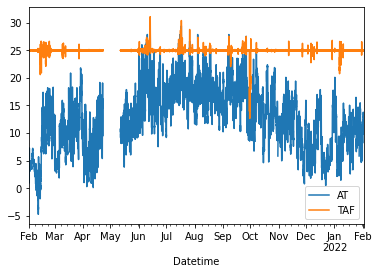

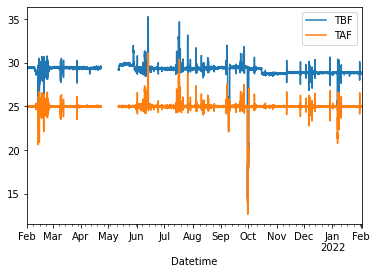

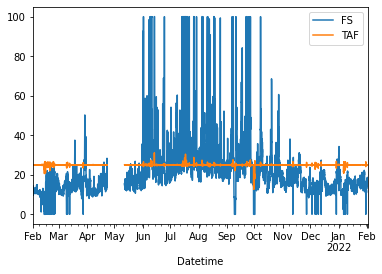

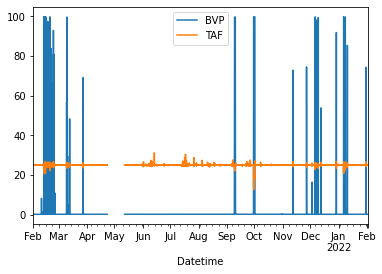

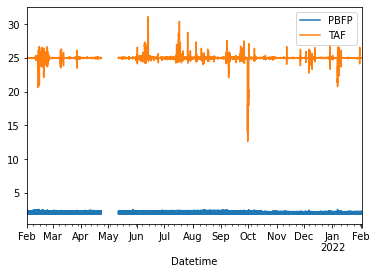

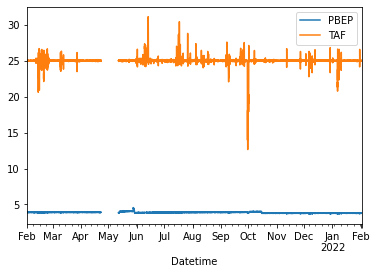

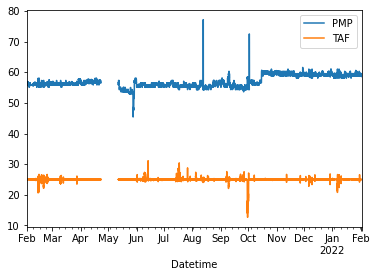

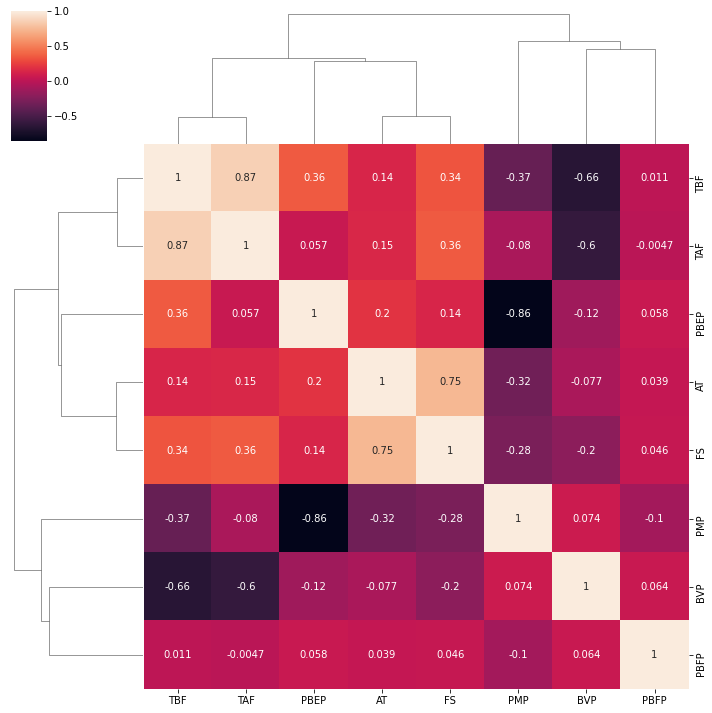

,count,mean,std,min,25%,50%,75%,max
AT,16626.0,12.580459,5.462818,-4.754266,8.794958,12.694966,16.497091,29.806566
TBF,16626.0,29.160691,0.924879,12.994333,28.879566,29.319683,29.430258,35.284266
TAF,16626.0,24.984992,0.574059,12.640966,24.981500,24.999933,25.018333,31.126866
FS,16652.0,21.992852,14.998815,0.000000,13.985416,18.331800,24.743599,100.000000
BVP,16652.0,1.846492,12.086943,0.138000,0.161400,0.169266,0.177066,99.789700
PBFP,16626.0,2.049240,0.139199,1.817233,1.932666,2.034183,2.152166,2.543166
PBEP,16624.0,3.873329,0.079843,3.632433,3.786466,3.895849,3.911266,4.569500
PMP,16616.0,56.959538,1.878153,45.431693,55.858639,56.603420,58.837766,77.209002


In [10]:
# Data import
data = pd.read_csv("closed_cooled_water_system_data.csv", index_col=0, parse_dates=True)

# Renaming the columns
mapping = {data.columns[0]: 'AT', 
           data.columns[1]:'TBF', 
           data.columns[2]: 'TAF', 
           data.columns[3]:'FS', 
           data.columns[4]: 'BVP', 
           data.columns[5]:'PBFP', 
           data.columns[6]: 'PBEP', 
           data.columns[7]:'PMP'}
data = data.rename(columns=mapping)

# All the caracteristics in relation to the time and compard to the Temperature After Fan
data.plot(y=["AT", "TAF"])
data.plot(y=["TBF", "TAF"])
data.plot(y=["FS", "TAF"])
data.plot(y=["BVP", "TAF"])
data.plot(y=["PBFP", "TAF"])
data.plot(y=["PBEP", "TAF"])
data.plot(y=["PMP", "TAF"])

# https://towardsdatascience.com/advanced-time-series-analysis-in-python-decomposition-autocorrelation-115aa64f475e
correlation = data.corr()
sns.clustermap(correlation, annot=True, square=True) # Normally the pearson metric is used here
plt.show()

data.describe().transpose()


## Étude de métriques de régression

<AxesSubplot:xlabel='Datetime'>

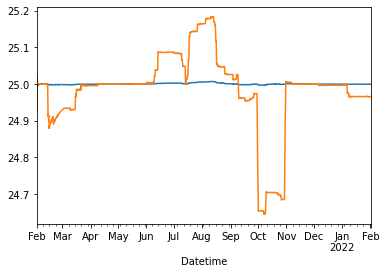

In [11]:
# Moving average and median on a 30 days span
data.TAF.rolling('30d').median().plot()
data.TAF.rolling('30d').mean().plot()

<AxesSubplot:xlabel='Datetime'>

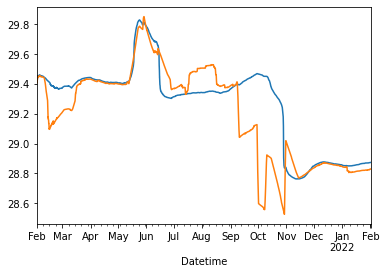

In [12]:
# Moving average and median on a 30 days span
data.TBF.rolling('30d').median().plot()
data.TBF.rolling('30d').mean().plot()

<AxesSubplot:xlabel='Datetime'>

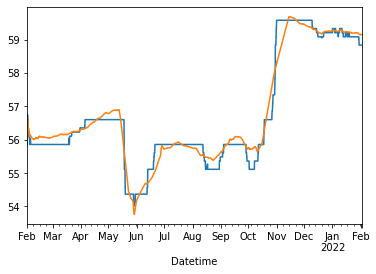

In [13]:
# Moving average and median on a 30 days span
data.PMP.rolling('30d').median().plot()
data.PMP.rolling('30d').mean().plot()

## Extraction des caractéristiques

### Les features les plus impactantes sur la température après le refroidissement (valeurs récupérées sur la table de correlation)

In [14]:
subset = data[["TBF", "TAF", "PBEP", "AT", "FS"]] # We keep the most correlated time features

## Remplissage des données manquantes

### Remplissage des données manquantes avec un interval de 30 min en utilisant la moyenne

In [15]:
subset.index = pd.to_datetime(subset.index)
filled_df = pd.DataFrame({}, columns=subset.columns)
for column in subset:
    filled_df[column] = subset[column].resample('30min').mean().ffill()

#### Comparaison entre le dataframe manquant des données et le dataframe rempli

<AxesSubplot:xlabel='Datetime'>

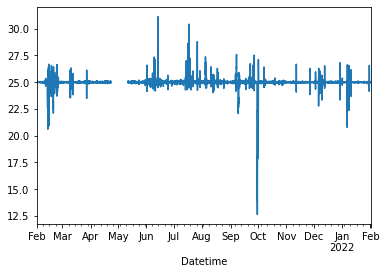

In [16]:
subset.TAF.plot()

<AxesSubplot:xlabel='Datetime'>

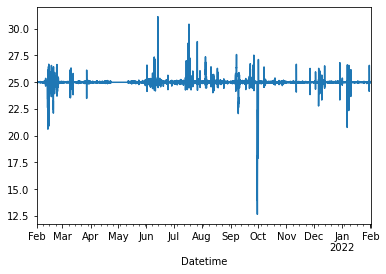

In [17]:
filled_df.TAF.plot()


## Implémentation, validation et test du FFNN avec keras

In [18]:
from tensorflow import keras
from sklearn import preprocessing

In [19]:
# Here we split the dataset in train, validation and test sets.
# Furthermore, for the features, we pop out the TAF column which is the label.
# Finally, we drop the last row of the features because it doesn't have any correspondance after the shift(-1) of the labels.
# The shift is done because we need to predict the value 30 minutes in the future.
# Dropna will thus drop the row with a NaN label.
# And the .TAF will keep the label column.

final_features_df = filled_df.drop(["TAF"], axis=1)[:-1]
final_labels_df = filled_df.shift(-1).dropna().TAF

train_features = final_features_df[:"2021-10-01"]
validation_features = final_features_df["2021-10-01":"2021-12-01"]
test_features = final_features_df["2021-12-01":]

train_labels = final_labels_df[:"2021-10-01"]
validation_labels = final_labels_df["2021-10-01":"2021-12-01"]
test_labels = final_labels_df["2021-12-01":]


In [20]:
train_features

,TBF,PBEP,AT,FS
Datetime,,,,
2021-02-01 00:00:00,29.427600,3.903533,1.900900,12.571866
2021-02-01 00:30:00,29.465433,3.898700,1.707766,14.426733
2021-02-01 01:00:00,29.435166,3.903133,1.369866,13.893233
2021-02-01 01:30:00,29.388200,3.906766,1.474700,12.907733
2021-02-01 02:00:00,29.419700,3.911200,1.252166,9.575700
...,...,...,...,...
2021-10-01 21:30:00,29.265233,3.928433,13.738866,17.856633
2021-10-01 22:00:00,29.268900,3.919966,13.565600,18.198866
2021-10-01 22:30:00,29.315200,3.929866,13.249400,17.963600


In [21]:
min_max_scaler = preprocessing.MinMaxScaler()
train_features[train_features.columns] = min_max_scaler.fit_transform(train_features)
validation_features[validation_features.columns] = min_max_scaler.transform(validation_features)
test_features[test_features.columns] = min_max_scaler.transform(test_features)

C:\Users\BRUNO~1.COS\AppData\Local\Temp/ipykernel_8980/1856769092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[train_features.columns] = min_max_scaler.fit_transform(train_features)
C:\Users\BRUNO~1.COS\AppData\Local\Temp/ipykernel_8980/1856769092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_features[validation_features.columns] = min_max_scaler.transform(validation_features)
C:\Users\BRUNO~1.COS\AppData\Local\Temp/ipykernel_8980/1856769092.py:4: SettingWithCopyWarnin

In [22]:
ffnn = keras.models.Sequential()
ffnn.add(keras.layers.Dense(units=16, activation="relu", input_shape=(train_features.shape[1],)))
ffnn.add(keras.layers.Dense(units=8, activation="relu"))
ffnn.add(keras.layers.Dense(units=1))

ffnn.compile(loss='mse',  # Mean squared error
             optimizer='RMSprop',  # Optimization algorithm
             metrics=['mse'])  # Mean squared error

history = ffnn.fit(train_features,  # Features
                   train_labels,  # Target vector
                   epochs=10,  # Number of epochs
                   verbose=1,
                   batch_size=30,  # Number of observations per batch
                   validation_data=(validation_features, validation_labels))  # Data for evaluation


Epoch 1/10
389/389 [==============================] - 1s 2ms/step - loss: 465.2049 - mse: 465.2049 - val_loss: 214.3266 - val_mse: 214.3266
Epoch 2/10
389/389 [==============================] - 1s 2ms/step - loss: 38.8011 - mse: 38.8011 - val_loss: 6.2582 - val_mse: 6.2582
Epoch 3/10
389/389 [==============================] - 1s 2ms/step - loss: 2.4172 - mse: 2.4172 - val_loss: 3.0619 - val_mse: 3.0619
Epoch 4/10
389/389 [==============================] - 1s 2ms/step - loss: 0.5346 - mse: 0.5346 - val_loss: 1.2449 - val_mse: 1.2449
Epoch 5/10
389/389 [==============================] - 1s 2ms/step - loss: 0.2384 - mse: 0.2384 - val_loss: 0.4938 - val_mse: 0.4938
Epoch 6/10
389/389 [==============================] - 1s 2ms/step - loss: 0.1386 - mse: 0.1386 - val_loss: 0.1406 - val_mse: 0.1406
Epoch 7/10
389/389 [==============================] - 1s 2ms/step - loss: 0.1084 - mse: 0.1084 - val_loss: 0.0387 - val_mse: 0.0387
Epoch 8/10
389/389 [==============================] - 1s 2ms/step 

In [23]:
test_results = ffnn.evaluate(test_features, test_labels, verbose=1)

95/95 [==============================] - 0s 1ms/step - loss: 0.1012 - mse: 0.1012


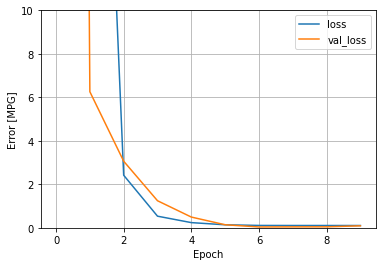

In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

## Comparaison entre la réalité et la prédiction

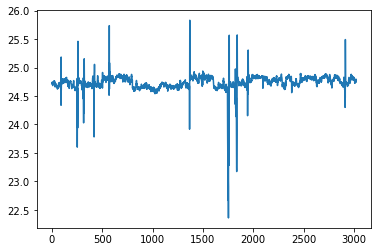

In [25]:
y = ffnn.predict(test_features)

plt.plot(range(test_features.shape[0]), y)

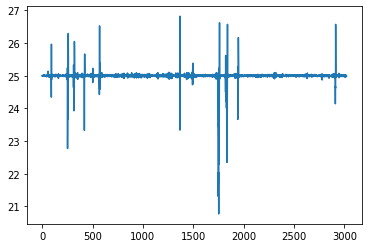

In [26]:
plt.plot(range(test_features.shape[0]), test_labels)

# SVR

In [27]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

train_features = final_features_df[:"2021-10-01"]
test_features = final_features_df["2021-10-01":]

train_labels = final_labels_df[:"2021-10-01"]
test_labels = final_labels_df["2021-10-01":]

regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

regr.fit(train_features, train_labels)
predictions = regr.predict(test_features)
print(mean_squared_error(test_labels, predictions))


0.1116735538661478


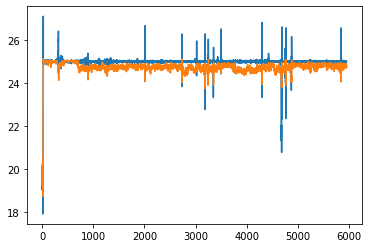

In [28]:
plt.plot(range(test_features.shape[0]), test_labels)
plt.plot(range(test_features.shape[0]), predictions)

In [29]:
parameters = {'C': [1e-2, 1e-3, 1, 0.1],
              'kernel': ['linear', 'rbf'],
              'gamma': [1e-2, 1e-3, 'auto']
              }
clf = SVR()
gs_clf = GridSearchCV(clf, parameters, cv=3)
gs_clf.fit(train_features, train_labels)
gs_clf.best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}

In [30]:
regr = make_pipeline(StandardScaler(), SVR(**gs_clf.best_params_))

regr.fit(train_features, train_labels)
predictions = regr.predict(test_features)
print(mean_squared_error(test_labels, predictions))

0.037063733472727095


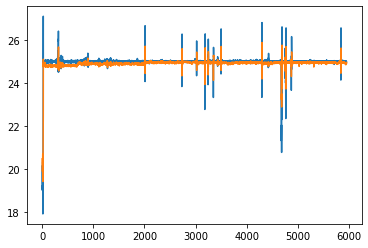

In [31]:
plt.plot(range(test_features.shape[0]), test_labels)
plt.plot(range(test_features.shape[0]), predictions)

# Arbre de décision - régressif

In [84]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

train_features = final_features_df[:"2021-10-01"]
test_features = final_features_df["2021-10-01":]

train_labels = final_labels_df[:"2021-10-01"]
test_labels = final_labels_df["2021-10-01":]

regr = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=0))

regr.fit(train_features, train_labels)
predictions = regr.predict(test_features)
print(mean_squared_error(test_labels, predictions))

0.11480755752674728


In [85]:
parameters = {'splitter': ['best', 'random'],
              'criterion': ['squared_error', 'friedman_mse'],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10]
              }
clf = DecisionTreeRegressor()
gs_clf = GridSearchCV(clf, parameters, cv=3)
gs_clf.fit(train_features, train_labels)
gs_clf.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 5,
 'min_samples_split': 10,
 'splitter': 'random'}

In [86]:
regr = make_pipeline(
    StandardScaler(), DecisionTreeRegressor(**gs_clf.best_params_))

regr.fit(train_features, train_labels)
predictions = regr.predict(test_features)
print(mean_squared_error(test_labels, predictions))

0.030374803150876067


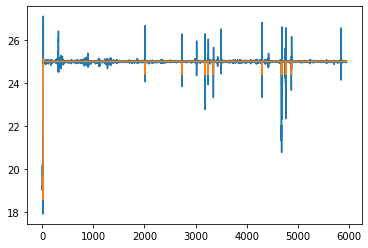

In [87]:
plt.plot(range(test_features.shape[0]), test_labels)
plt.plot(range(test_features.shape[0]), predictions)